<a href="https://colab.research.google.com/github/1337Rinz/AI_ML/blob/main/17_Lab09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data file path
# /content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress

In [ ]:
pip install pyvi

In [7]:
# import requirement lib
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

In [9]:
INPUT = "/content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress"
os.makedirs("images",exist_ok=True)
# thư mục lưu các hình ảnh kết quả trong quá trình huấn luyện và đánh giá

In [10]:
# statistics
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
n = 0
for label in os.listdir(INPUT):
    print(f'{label}: {len(os.listdir(os.path.join(INPUT, label)))}')
    n += len(os.listdir(os.path.join(INPUT, label)))
print('-------------------------')
print(f"Tổng số văn bản: {n}")

Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
giao-duc: 105
du-lich: 54
khoa-hoc: 144
giai-tri: 201
kinh-doanh: 262
suc-khoe: 162
doi-song: 120
phap-luat: 59
the-thao: 173
thoi-su: 59
-------------------------
Tổng số văn bản: 1339


In [11]:
# load data
data_train = load_files(container_path=INPUT, encoding="utf-8")
print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')
print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])

print(data_train.data[0:1])
print("\nTổng số  văn bản: {}" .format( len(data_train.filenames)))

mapping:
doi-song - 0
du-lich - 1
giai-tri - 2
giao-duc - 3
khoa-hoc - 4
kinh-doanh - 5
phap-luat - 6
suc-khoe - 7
the-thao - 8
thoi-su - 9
--------------------------
['/content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/news_vnexpress/khoa-hoc/00133.txt']
[4]
['Mời độc giả đặt câu hỏi tại đây\n']

Tổng số  văn bản: 1339


Tiền xử lý dữ liệu:
Chuyển dữ liệu dạng text về dạng số
Chuyển dữ liệu dạng text về ma trận (n x m) bằng TF. Chuyển nhãn các văn bản về
dạng số

In [13]:
# load dữ liệu các stopwords
with open("/content/drive/MyDrive/Đại Học/Học máy và ứng dụng/DATA/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])
# Chuyển hoá dữ liệu text về dạng vector TF
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data,
data_train.target)
print(f"\nSố lượng từ trong từ điển:{len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

Số lượng stopwords: 2063
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển:12796
Kích thước dữ liệu sau khi xử lý: (1339, 12796)
Kích thước nhãn tương ứng: (1339,)


Chia dữ liệu

In [15]:
# holdout
p = 0.2
pivot = int(data_preprocessed.shape[0] * (1-0.2))
X_train, X_test = data_preprocessed[0:pivot], data_preprocessed[pivot:]
Y_train, Y_test = data_train.target[0:pivot], data_train.target[pivot:]

In [16]:
# Lựa chọn (tối ưu) tham số / model selection
# Chỉ dùng tập train để thực hiện lựa chọn tham số.
# SVM: kernel, C
# Random Forest: criteria, N
# Ta sẽ dùng chiến lược Cross Validation trong bước này.

def cross_validation(estimator):
  _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
  test_scores = test_scores[0]
  mean, std = test_scores.mean(), test_scores.std()
  return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
  plt.xlabel(xlabel)
  plt.title(title)
  plt.grid()
  plt.ylabel(ylabel)

  plt.errorbar(X, Y, error, linestyle='None', marker='o')

100%|██████████| 4/4 [02:46<00:00, 41.54s/it]


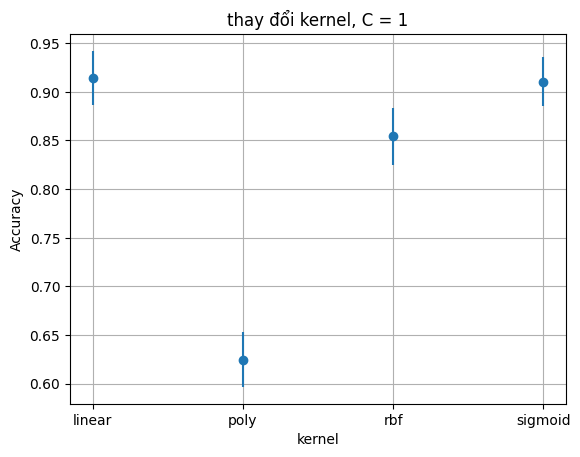

In [17]:
#evaluate effectiveness kernels in SVM

title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []
for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
  # Với mỗi kernel được chọn,
  # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
  text_clf = svm.SVC(kernel=kernel, C=1.0)
  mean, std = cross_validation(text_clf)
  X.append(kernel)
  Y.append(mean)
  error.append(std)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()

100%|██████████| 5/5 [02:52<00:00, 34.42s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

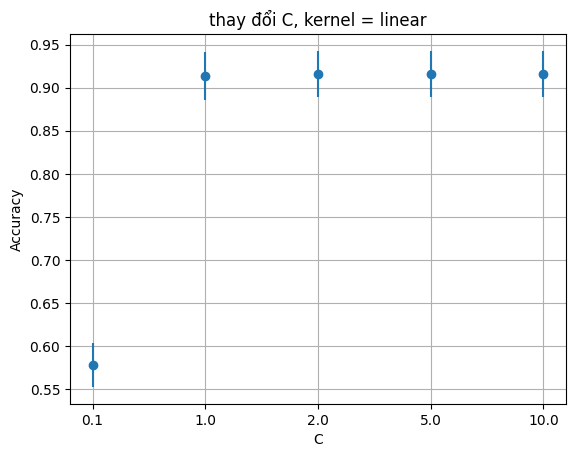

In [20]:
#evaluate impact assessment of C in SVM

title = "thay đổi C, kernel = linear"
xlabel = "C"
X = []
Y = []
error = []
for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
  # Với từng giá trị C nhận được,
  # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross- validation
  text_clf = svm.SVC(kernel='linear', C=C)
  mean, std = cross_validation(text_clf)
  X.append(str(C))
  Y.append(mean)
  error.append(std)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('/content/images/svm_change_C.png', bbox_inches='tight')
plt.show

100%|██████████| 2/2 [00:19<00:00,  9.86s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

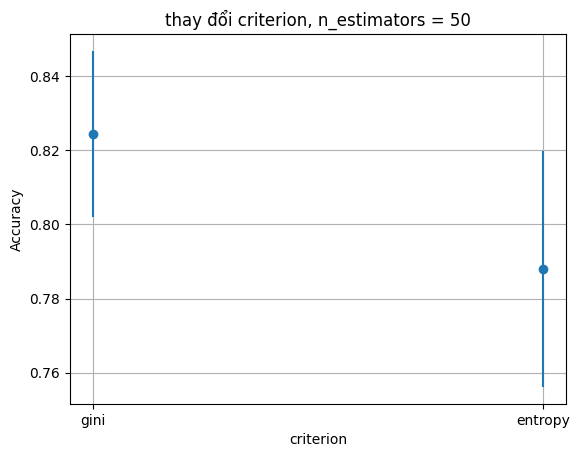

In [22]:

title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []
for criterion in tqdm(["gini", "entropy"]):
  # Với mỗi criterion nhận được,
  # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross- validation
  text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
  mean, std = cross_validation(text_clf)
  X.append(str(criterion))
  Y.append(mean)
  error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('/content/images/RF_change_criterion.png', bbox_inches='tight')
plt.show

100%|██████████| 4/4 [01:24<00:00, 21.12s/it]


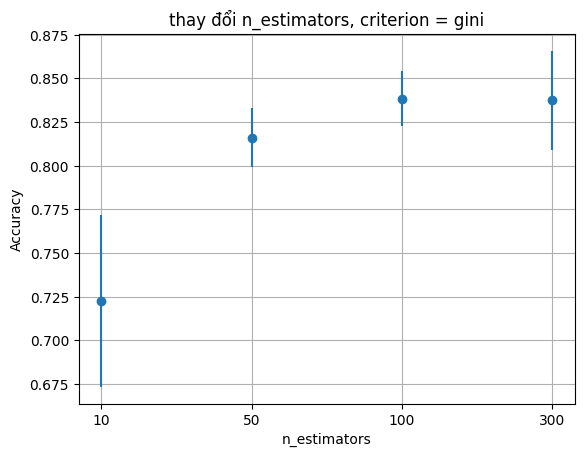

In [23]:
# Đánh giá ảnh hưởng của số cây trong Random Forest

title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []
for n_estimators in tqdm([10, 50, 100, 300]):
  # Với từng giá trị n_estimators nhận được,
  # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross- validation

  text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
  mean, std = cross_validation(text_clf)
  X.append(str(n_estimators))
  Y.append(mean)
  error.append(std)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('/content/images/RF_change_N.png', bbox_inches='tight')
plt.show()

SVM: 0.9253731343283582
RF: 0.8208955223880597


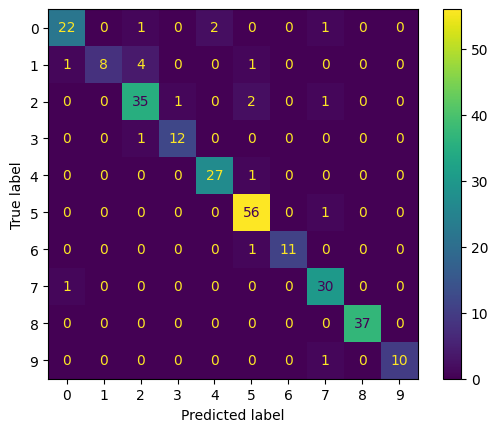

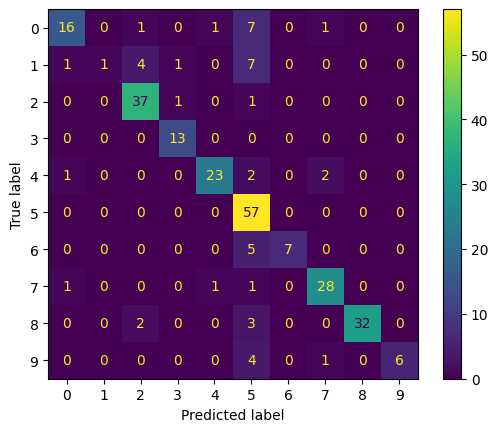

In [25]:
#  So sánh các mô hình
#  Sau khi chọn được các bộ tham số tốt nhất cho mỗi mô hình, ta huấn luyện lại trên toàn bộ tập Train.
#  Dùng các mô hình mới huấn luyện để phán đoán cho các dữ liệu trong tập Test
#  Đo đạc Độ chính xác (Accuracy) của chúng và so sánh kết quả.

svm_ = svm.SVC(kernel='linear', C=1.0)
rf = RandomForestClassifier(criterion='gini', n_estimators=100)
# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

# Kết quả dự đoán trên tập test
print(f'SVM: {accuracy_score(Y_test, svm_.predict(X_test))}')
print(f'RF: {accuracy_score(Y_test, rf.predict(X_test))}')

# Show confusion matrix SVM
predictions = svm_.predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=svm_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm_.classes_)
disp.plot()
plt.show()

# Show confusion matrix RF
predictions = rf.predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=svm_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm_.classes_)
disp.plot()
plt.show()

In [26]:
# Kết quả dự đoán trên tập test
print(f'SVM: {accuracy_score(Y_test, svm_.predict(X_test))}')
print(f'RF: {accuracy_score(Y_test, rf.predict(X_test))}')

SVM: 0.9253731343283582
RF: 0.8208955223880597


In [29]:
print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')

mapping:
doi-song - 0
du-lich - 1
giai-tri - 2
giao-duc - 3
khoa-hoc - 4
kinh-doanh - 5
phap-luat - 6
suc-khoe - 7
the-thao - 8
thoi-su - 9
